# Zbozinek TD, Perez OD, Wise T, Fanselow M, & Mobbs D

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import scan
import theano.tensor as T
import pymc3 as pm
import theano
import seaborn as sns
import os, sys, subprocess
import pickle

# Load Data

In [6]:
data = pd.read_csv(os.path.join('../data/', "2nd_POS_Modeling_Data_Direct_Associations.csv"))

In [7]:
data['DV'] = ((data['DV'].values - 1) / 2) - 1

observed_R = data.pivot(columns = 'ID', index = 'trialseq', values = 'DV').values[:, np.newaxis, :] #values.T transposes the data, so you can make trials the first dimension or participants first

# Direct Associations Model

In [8]:
def learning_function(stimuli_shown, Λ, λ, training_or_test, prev_V, prev_Vbar, stimulus_type, α):
    
    Λbar = T.zeros_like(Λ)
    Λbar = T.inc_subtensor(Λbar[0,:], (prev_V[2,:] > 0) * (1 - Λ[0, :])) #Dcs
    Λbar = T.inc_subtensor(Λbar[1,:], (prev_V[1,:] > 0) * (1 - Λ[1, :])) #Ecs
    Λbar = T.inc_subtensor(Λbar[2,:], (prev_V[2,:] > 0) * (1 - Λ[2, :])) #F
    Λbar = T.inc_subtensor(Λbar[3,:], (prev_V[2,:] > 0) * (1 - Λ[3, :])) #S
    Λbar = T.inc_subtensor(Λbar[4,:], (prev_V[4,:] > 0) * (1 - Λ[4, :])) #G
    Λbar = T.inc_subtensor(Λbar[5,:], (prev_V[4,:] > 0) * (1 - Λ[5, :])) #H
    Λbar = T.inc_subtensor(Λbar[6,:], (prev_V[6,:] > 0) * (1 - Λ[6, :])) #Mcs
    Λbar = T.inc_subtensor(Λbar[7,:], (prev_V[7,:] > 0) * (1 - Λ[7, :])) #N
    Λbar = T.inc_subtensor(Λbar[8,:], (prev_V[7,:] > 0) * (1 - Λ[8, :])) #Ucs
      
    #λbar Scaling
    λbar = T.zeros_like(Λbar)
    λbar = T.inc_subtensor(λbar[0,:], prev_V[2,:]) #Dcs
    λbar = T.inc_subtensor(λbar[1,:], prev_V[1,:]) #Ecs
    λbar = T.inc_subtensor(λbar[2,:], prev_V[2,:]) #F
    λbar = T.inc_subtensor(λbar[3,:], prev_V[2,:]) #S
    λbar = T.inc_subtensor(λbar[4,:], prev_V[4,:]) #G
    λbar = T.inc_subtensor(λbar[5,:], prev_V[4,:]) #H
    λbar = T.inc_subtensor(λbar[6,:], prev_V[6,:]) #Mcs
    λbar = T.inc_subtensor(λbar[7,:], prev_V[7,:]) #N
    λbar = T.inc_subtensor(λbar[8,:], prev_V[7,:]) #Ucs


    pe_V = λ - prev_V
    pe_Vbar = λbar - prev_Vbar
    
    ΔV = Λ * (α) * pe_V
    ΔVbar = Λbar * (α) * pe_Vbar


    # Only update stimuli that were shown
    ΔV = ΔV * stimuli_shown
    ΔVbar = ΔVbar * stimuli_shown
    
    # Update V, Vbar
    V = T.zeros_like(prev_V)
    Vbar = T.zeros_like(prev_Vbar)
    
    # Only update V and Vbar for CSs.
    V = T.inc_subtensor(V[T.eq(stimulus_type, 1)], prev_V[T.eq(stimulus_type, 1)] + ΔV[T.eq(stimulus_type, 1)] * training_or_test)
    Vbar = T.inc_subtensor(Vbar[T.eq(stimulus_type, 1)], prev_Vbar[T.eq(stimulus_type, 1)] + ΔVbar[T.eq(stimulus_type, 1)] * training_or_test)
    
    return V, Vbar

# Generate Simulated Data with Model

In [10]:
n_stim = 9
n_subjects = len(data['ID'].unique())

#Initial values
R = np.zeros((n_stim, n_subjects))
overall_R = np.zeros((1, n_subjects))
v_excitatory = np.zeros((n_stim, n_subjects))
v_inhibitory = np.zeros((n_stim, n_subjects))

#Randomized parameter values - use this if you want to compare simulated vs recovered parameters and comment out the "α = 1" code in the subsequent lines
gen_dist = pm.Beta.dist(2, 2, shape = n_subjects)
α_subject_sim = gen_dist.random()

#α = 1 - use this if you want to create the Individual vs Real figures at the bottom of this notebook
# gen_dist = pm.Beta.dist(2, 2, shape=n_subjects)
# α_subject_sim = np.ones(n_subjects)

#Test vs Training Trial
training_or_test = data.pivot(index='trialseq', values='Test', columns='ID').values[:, np.newaxis, :].astype(float)

#US values
small_lambda = data.pivot(index='trialseq', values='US', columns='ID').values[:, np.newaxis, :].repeat(n_stim, axis=1).astype(float)
stim_data = []

for sub in data['ID'].unique():
    stim_data.append(data.loc[data['ID'] == sub, ['Dcs', 'Ecs', 'F', 'S', 'G', 'H', 'Mcs', 
                                                  'N', 'Ucs']].values)

stimuli_shown = np.dstack(stim_data)
big_lambda = small_lambda

#Add imaginary -1th trial
big_lambda = np.vstack([np.zeros((1, n_stim, n_subjects)), big_lambda[:-1, ...]]).astype(float) # Add one trial of zeros to the start, remove the last trial
small_lambda = big_lambda
stimuli_shown = np.vstack([np.zeros((1, n_stim, n_subjects)), stimuli_shown]) # Add one trial of zeros to the start, DO NOT remove the last trial - this is needed for prediction

stimulus_type = np.ones(n_stim)

#Convert task outcomes to tensors
big_lambda = T.as_tensor_variable(big_lambda.astype(float))
small_lambda = T.as_tensor_variable(small_lambda.astype(float))
stimuli_shown = T.as_tensor_variable(stimuli_shown)
training_or_test = T.as_tensor_variable(training_or_test)

stimuli_shown_sim = stimuli_shown.copy()
big_lambda_sim = big_lambda.copy()
small_lambda_sim = small_lambda.copy()
training_or_test_sim = training_or_test.copy()

# Run Fake Data Simulation

In [11]:
#Run the loop
output, updates = scan(fn=learning_function,
                    sequences=[{'input': stimuli_shown_sim[:-1, ...]},
                             {'input': big_lambda_sim},
                             {'input': small_lambda_sim},
                              {'input': training_or_test}],
                    outputs_info=[v_excitatory, v_inhibitory],
                    non_sequences = [stimulus_type, α_subject_sim])

#Get model output
V_out, Vbar_out = [i.eval() for i in output]

estimated_overall_R = (V_out * stimuli_shown_sim[1:, ...]).sum(axis=1) - (Vbar_out * stimuli_shown_sim[1:, ...]).sum(axis=1)
                   
overall_R_sim = estimated_overall_R.eval()

# Check parameter recovery

In [12]:
n_subjects = len(data['ID'].unique())

#Initial values
R = np.zeros((n_stim, n_subjects))

#US values
small_lambda = data.pivot(index='trialseq', values='US', columns='ID').values[:, np.newaxis, :].repeat(n_stim, axis=1).astype(float)
stim_data = []

for sub in data['ID'].unique():
    stim_data.append(data.loc[data['ID'] == sub, ['Dcs', 'Ecs', 'F', 'S', 'G', 'H', 'Mcs', 
                                                  'N', 'Ucs']].values)

stimuli_shown = np.dstack(stim_data)
big_lambda = small_lambda

#Add imaginary -1th trial
big_lambda = np.vstack([np.zeros((1, n_stim, n_subjects)), big_lambda[:-1, ...]]).astype(float) # Add one trial of zeros to the start, remove the last trial
small_lambda = np.vstack([np.zeros((1, n_stim, n_subjects)), small_lambda[:-1, ...]]).astype(float) # Add one trial of zeros to the start, remove the last trial
stimuli_shown = np.vstack([np.zeros((1, n_stim, n_subjects)), stimuli_shown]) # Add one trial of zeros to the start, DO NOT remove the last trial - this is needed for prediction



#Convert task outcomes to tensors
big_lambda = T.as_tensor_variable(big_lambda.astype(float))
small_lambda = T.as_tensor_variable(small_lambda.astype(float))
stimuli_shown = T.as_tensor_variable(stimuli_shown)

stimulus_type = np.ones(n_stim)

with pm.Model() as model:
    
    # Learning rate lies between 0 and 1
    α_mean = pm.Normal('α_mean', 0.5, 10)
    α_sd = pm.HalfCauchy('α_sd', 10)
    

    
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
    α_subject = BoundedNormal('α', mu=α_mean, sd=α_sd, shape=(n_subjects,))

    
    # Run the loop
    output, updates = scan(fn=learning_function,
                      sequences=[{'input': stimuli_shown[:-1, ...]},
                             {'input': big_lambda},
                             {'input': small_lambda},
                                {'input': training_or_test}],
                      outputs_info=[v_excitatory, v_inhibitory],
                      non_sequences=[stimulus_type, α_subject])
    
    # Get model output
    V, Vbar = output

    # # Single R value
    estimated_overall_R = ((V * stimuli_shown[1:, ...]).sum(axis=1) - (Vbar * stimuli_shown[1:, ...]).sum(axis=1))
                           
    # This allows us to output the estimated R
    estimated_overall_R = pm.Deterministic('estimated_overall_R', estimated_overall_R)
    V = pm.Deterministic('estimated_V', V)
    Vbar = pm.Deterministic('estimated_Vbar', Vbar)    
    
    # Reshape output of the model and get categorical likelihood
    sigma = pm.HalfCauchy('sigma', 0.5)
    likelihood = pm.Normal('likelihood', mu=estimated_overall_R, sigma=sigma, observed=pd.DataFrame(overall_R_sim.squeeze()))

# Fit the Model

#### Variational Inference

In [13]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    approx = pm.fit(method='advi', n=25000, callbacks=[CheckParametersConvergence()])

Average Loss = -79,465: 100%|██████████| 25000/25000 [1:13:11<00:00,  5.69it/s]
Finished [100%]: Average Loss = -79,470


In [14]:
trace = approx.sample(1000)

In [15]:
#Saves model results; optional
with open('Exp2_DA_Simulated.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [ ]:
#Loads model results; optional
trace = pickle.load(open('Exp2_DA_Simulated.pkl', 'rb'))

In [16]:
parameter_output = pm.summary(trace, kind='stats', varnames=[i for i in model.named_vars if 'α' in i and not i in model.deterministics and not 'log' in i and not 'interval' in i])

C:\Users\tzboz\anaconda3\lib\site-packages\pymc3\stats\__init__.py:19: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(


In [17]:
recovered_data_var = {'Simulated_α': α_subject_sim, 'Recovered_α': trace['α'].mean(axis=0)}
recovered_data_var = pd.DataFrame(recovered_data_var)
recovered_data_var.to_csv(os.path.join('../output/',r'Exp2_DA_Simulated_vs_Recovered_Parameters.csv'))

C:\Users\tzboz\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


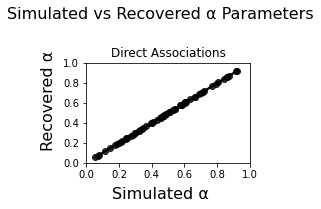

In [18]:
f, ax = plt.subplots(1, 1, sharex = True, sharey = True, figsize=(3, 2.5))
f.suptitle('Simulated vs Recovered α Parameters', y=1.02, fontsize = 16)
f.text(.5, -.02, 'Simulated α', va='center', ha='center', fontsize = 16)
f.text(-.02, .5, 'Recovered α', va='center', ha='center', fontsize = 16, rotation=90)

sns.regplot(α_subject_sim, trace['α'].mean(axis=0), label='α_subject', color = 'black')

ax.set_title('Direct Associations')

plt.setp(ax, xticks=[0, .2, .4, .6, .8, 1], yticks=[0, .2, .4, .6, .8, 1])        
plt.tight_layout()

plt.savefig(os.path.join('../output/',r'Exp2_DA_Simulated_vs_Recovered.svg'), bbox_inches='tight')

# Fit the Model to Real Data

In [14]:
n_subjects = len(data['ID'].unique())

# Initial values
R = np.zeros((n_stim, n_subjects))  # Value estimate
overall_R = np.zeros((1, n_subjects))
v_excitatory = np.zeros((n_stim, n_subjects)) 
v_inhibitory = np.zeros((n_stim, n_subjects))

# US values
small_lambda = data.pivot(index='trialseq', values='US', columns='ID').values[:, np.newaxis, :].repeat(n_stim, axis=1)
stim_data = []

for sub in data['ID'].unique():
    stim_data.append(data.loc[data['ID'] == sub, ['Dcs', 'Ecs', 'F', 'S', 'G', 'H', 'Mcs', 
                                                  'N', 'Ucs']].values)
    
stimuli_shown = np.dstack(stim_data)
big_lambda = small_lambda

# Add imaginary -1th trial
big_lambda = np.vstack([np.zeros((1, n_stim, n_subjects)), big_lambda[:-1, ...]])  # Add one trial of zeros to the start, remove the last trial
small_lambda = np.vstack([np.zeros((1, n_stim, n_subjects)), small_lambda[:-1, ...]])  # Add one trial of zeros to the start, remove the last trial
stimuli_shown = np.vstack([np.zeros((1, n_stim, n_subjects)), stimuli_shown]) # Add one trial of zeros to the start, DO NOT remove the last trial - this is needed for prediction

stimulus_type = np.ones(n_stim)


# Convert task outcomes to tensors
big_lambda = T.as_tensor_variable(big_lambda)
small_lambda = T.as_tensor_variable(small_lambda)
stimuli_shown = T.as_tensor_variable(stimuli_shown)

with pm.Model() as model:
    
    # Learning rate lies between 0 and 1 so we use a beta distribution
    α_mean = pm.Normal('α_mean', 0.5, 10)
    α_sd = pm.HalfCauchy('α_sd', 10)


    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1)
    α_subject = BoundedNormal('α', mu=α_mean, sd=α_sd, shape=(n_subjects,))

    
    # Run the loop
    output, updates = scan(fn=learning_function,
                      sequences=[{'input': stimuli_shown[:-1, ...]},
                             {'input': big_lambda},
                             {'input': small_lambda},
                                {'input': training_or_test}],
                      outputs_info=[v_excitatory, v_inhibitory],
                      non_sequences=[stimulus_type, α_subject])
    
    # Get model output
    V, Vbar = output
    
    estimated_overall_R = ((V * stimuli_shown[1:, ...]).sum(axis=1) - (Vbar * stimuli_shown[1:, ...]).sum(axis=1))
    
    # This allows us to output the estimated R
    estimated_overall_R = pm.Deterministic('estimated_overall_R', estimated_overall_R)
    V = pm.Deterministic('estimated_V', V)
    Vbar = pm.Deterministic('estimated_Vbar', Vbar)
          
    # Reshape output of the model and get categorical likelihood
    sigma = pm.HalfCauchy('sigma', 0.5)
    likelihood = pm.Normal('likelihood', mu=estimated_overall_R, sigma=sigma, observed=pd.DataFrame(observed_R.squeeze()))

#### Variational Inference

In [15]:
from pymc3.variational.callbacks import CheckParametersConvergence
with model:
    approx = pm.fit(method='advi', n=25000, callbacks=[CheckParametersConvergence()])

Average Loss = 26,575: 100%|██████████| 25000/25000 [1:12:27<00:00,  5.75it/s] 
Finished [100%]: Average Loss = 26,575


In [16]:
trace = approx.sample(1000)

In [17]:
#Saves model results; optional
with open('Exp2_DA.pkl', 'wb') as f:
    pickle.dump(trace, f)

In [ ]:
#Loads model results; optional
trace = pickle.load(open('Exp2_DA.pkl', 'rb'))

In [18]:
parameter_output = pm.summary(trace, kind='stats', varnames=[i for i in model.named_vars if 'α' in i and not i in model.deterministics and not 'log' in i and not 'interval' in i])

C:\Users\tzboz\anaconda3\lib\site-packages\pymc3\stats\__init__.py:19: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(


# Model Output

In [19]:
overall_R_mean = trace['estimated_overall_R'].mean(axis=0)
overall_R_sd = trace['estimated_overall_R'].std(axis=0)
sub_ids = data['ID'].unique()
subs = [np.where(data['ID'].unique() == sub)[0][0] for sub in sub_ids]

In [20]:
waic_output = pm.waic(trace)

C:\Users\tzboz\anaconda3\lib\site-packages\arviz\stats\stats.py:1194: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [21]:
waic_output

Computed from 1000 by 22981 log-likelihood matrix

        Estimate       SE
IC_waic 53330.13   163.24
p_waic    343.25        -

There has been a warning during the calculation. Please check the results.

In [22]:
parameter_output.to_csv(os.path.join('../output/',r'Exp2_DA_Parameters.csv'))
waic_output.to_csv(os.path.join('../output/',r'Exp2_DA_WAIC.csv'))

In [23]:
from sklearn.metrics import r2_score
r2s = []
for n, sub in enumerate(data['ID'].unique()):
    r2s.append(r2_score(observed_R.squeeze()[:, n], overall_R_mean[:, n]))
group_r2 = np.median(r2s)
print(group_r2)

0.17619001448690463


In [24]:
r2s = {'R2': [r2s]}
r2s = pd.DataFrame(r2s)
r2s.to_csv(os.path.join('../output/',r'Exp2_DA_R2.csv'))

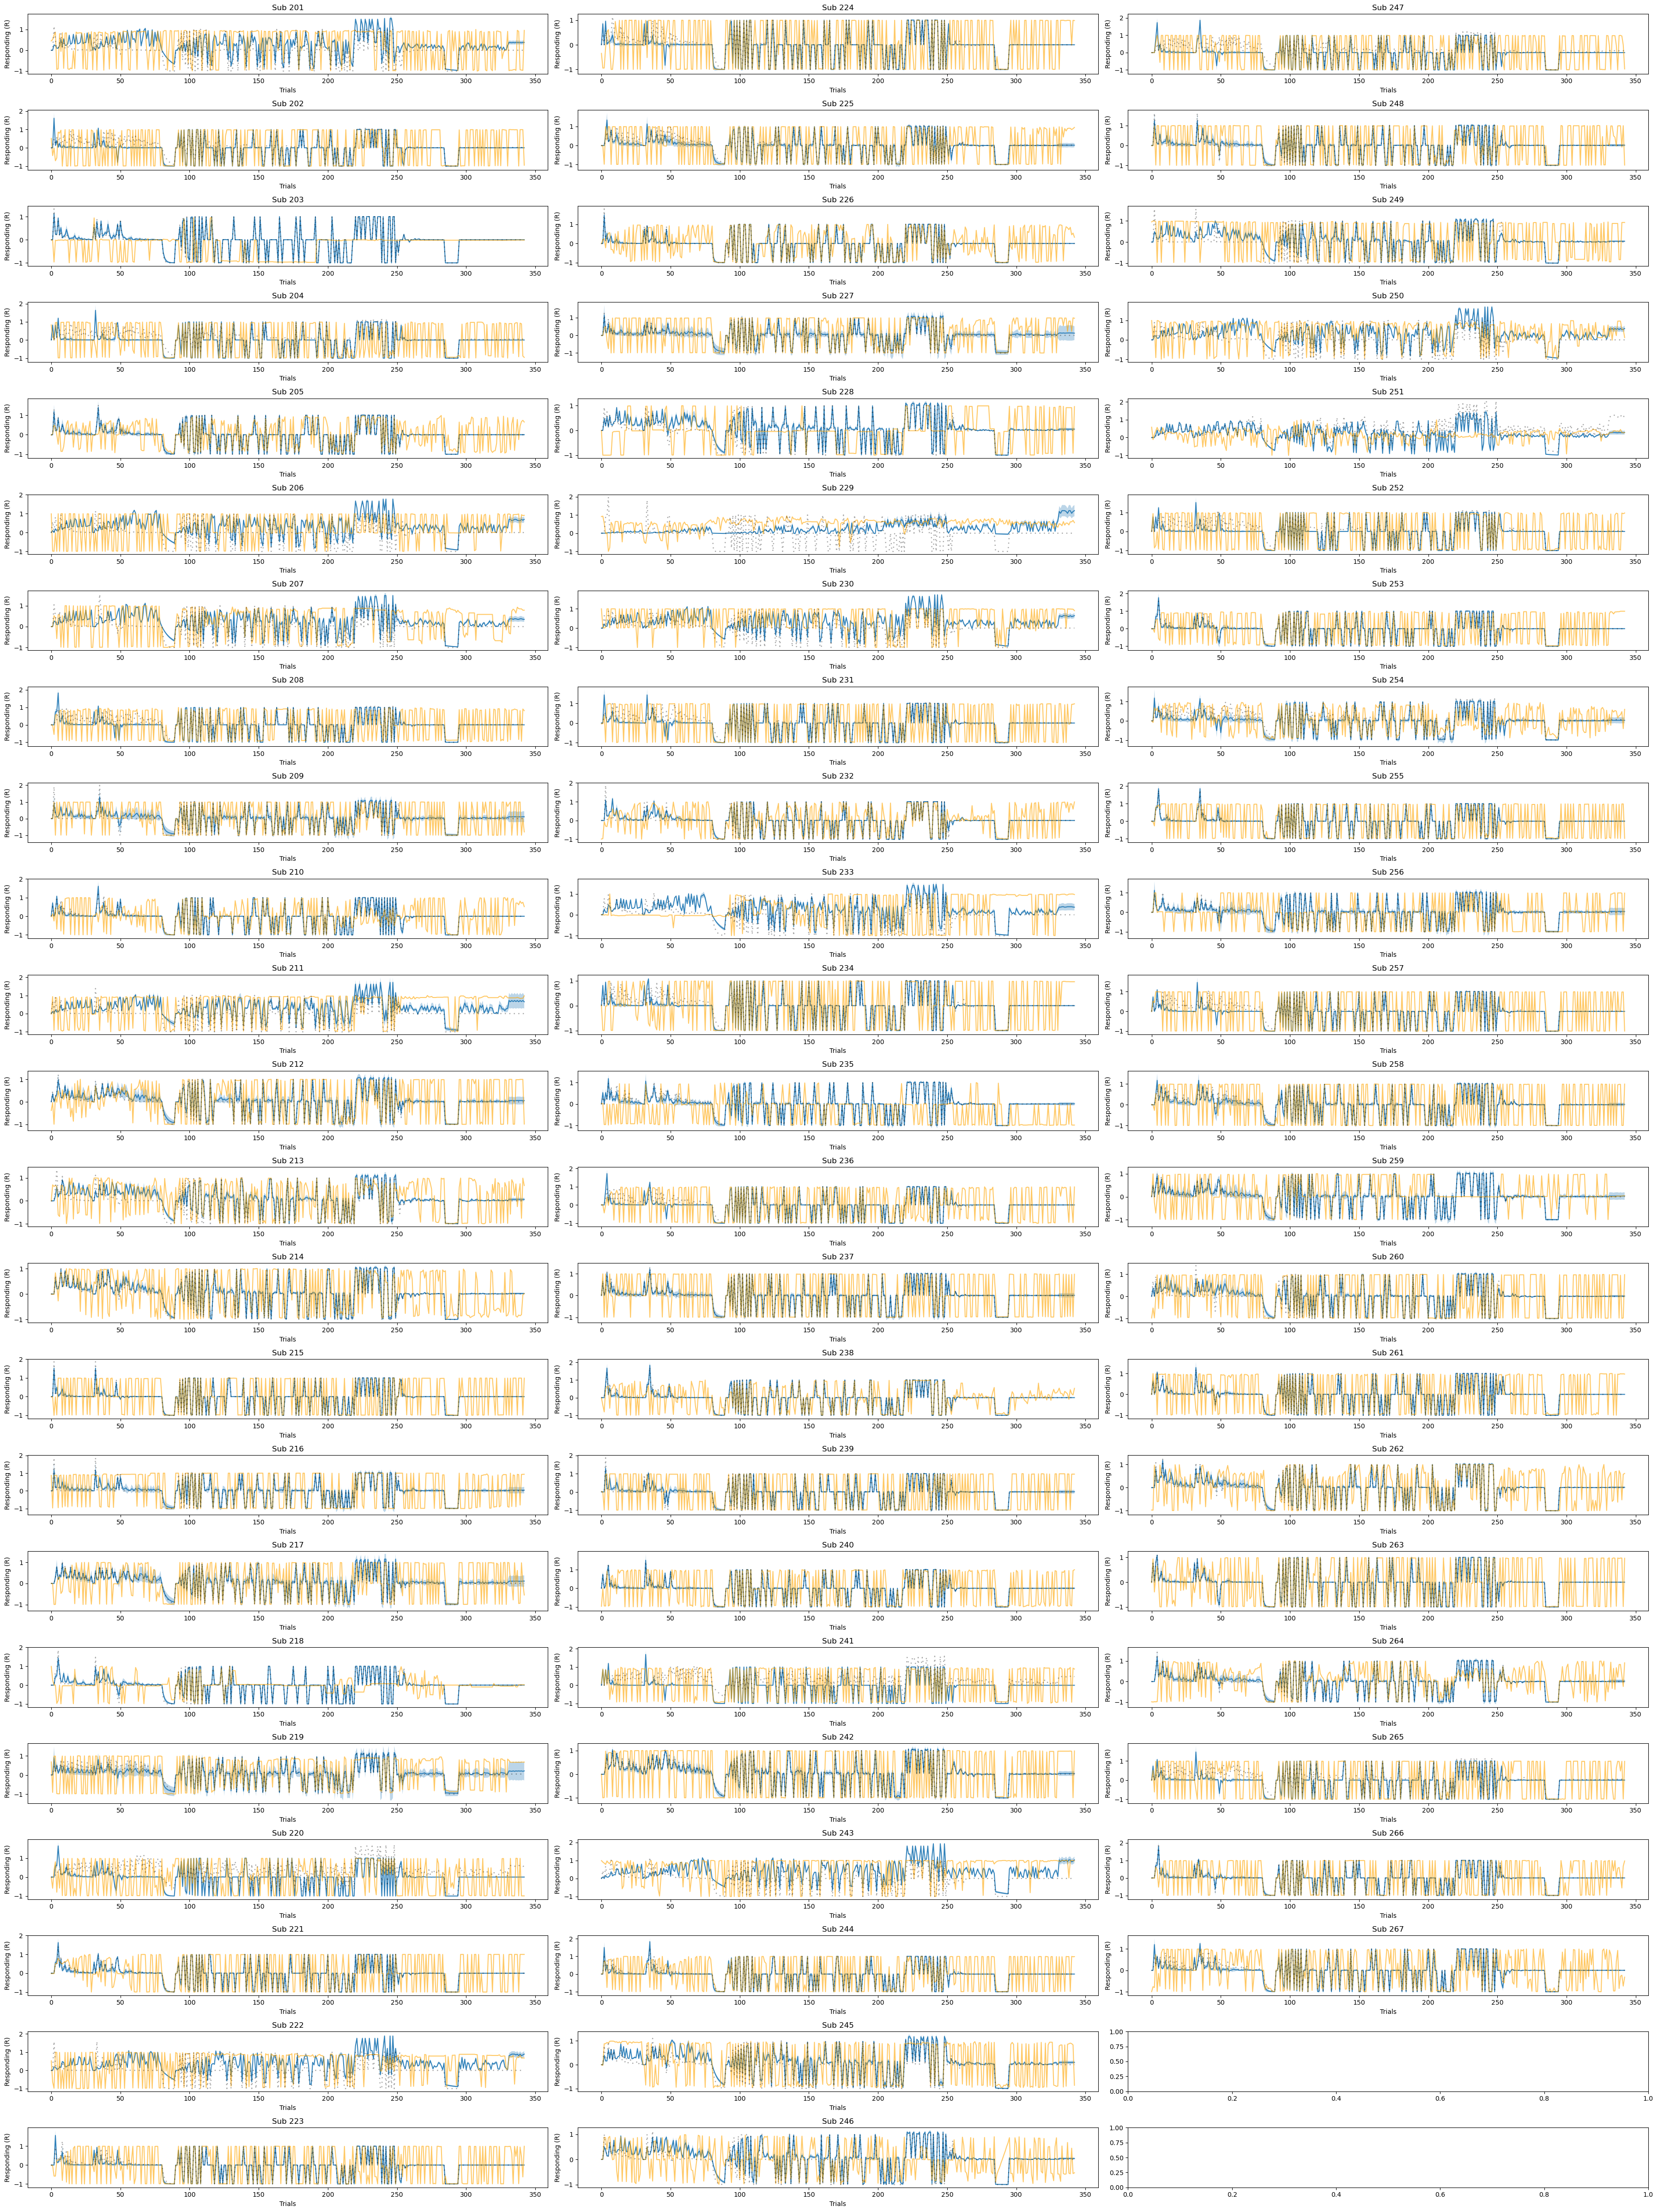

In [25]:
f, ax = plt.subplots(23, 3, figsize=(36, 48), dpi = 100)

overall_R_mean = trace['estimated_overall_R'].mean(axis=0)
overall_R_sd = trace['estimated_overall_R'].std(axis=0)

sub_ids = data['ID'].unique()

subs = [np.where(data['ID'].unique() == sub)[0][0] for sub in sub_ids]
    

for n, sub in enumerate(subs):
    ax[n % 23, int(n / 23)].fill_between(range(overall_R_mean.shape[0]), overall_R_mean[:, sub] - overall_R_sd[:, sub], overall_R_mean[:, sub] + overall_R_sd[:, sub], alpha=0.3)
    ax[n % 23, int(n / 23)].plot(overall_R_mean[:, sub], alpha = .9)
    ax[n % 23, int(n / 23)].plot(observed_R.squeeze()[:, sub], color='orange', linestyle='-', alpha = .6)#participant's real data
    ax[n % 23, int(n / 23)].plot(overall_R_sim.squeeze()[:, sub], color='black', linestyle=(0, (1, 3)), alpha = .35, linewidth = 1.75)#Alpha = 1; this is the correct answer if a person learned perfectly
    if n == 0:
        ax[n % 23, int(n / 23)].set_ylabel('Mean (+/-SD) overall R')
    ax[n % 23, int(n / 23)].set_ylabel('Responding (R)')
    ax[n % 23, int(n / 23)].set_xlabel('Trials')
    ax[n % 23, int(n / 23)].set_title('Sub {0}'.format(sub_ids[n]))   

plt.tight_layout()
plt.savefig(os.path.join('../output/',r'Exp2_DA_Individual_Real_and_Estimated_Responding.svg'), bbox_inches='tight')

In [ ]:
%load_ext watermark
%watermark -v -p pytest,jupyterlab,numpy,pandas,theano,pymc3